# 4장 신경망 활용: 분류와 회귀

__감사말__: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 3장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

__구글 코랩 설정__: '런타임 -> 런타임 유형 변경' 메뉴에서 GPU를 지정한다.
이후 아래 명령어를 실행했을 때 오류가 발생하지 않으면 필요할 때 GPU가 자동 사용된다.

```
!nvidia-smi
```

구글 코랩에서 사용되는 tensorflow 버전을 확인하려면 아래 명령문을 실행한다.

```python
import tensorflow as tf
tf.__version__
```

tensorflow가 GPU를 사용하는지 여부를 알고 싶으면 
주피터 노트북 등 사용하는 편집기 및 파이썬 터미널에서 아래 명령문을 실행한다.

```python
import tensorflow as tf
tf.config.list_physical_devices('GPU')
```

## 주요 내용

- 머신러닝 실전 예제: 분류와 회귀
    - 이항 분류
    - 다중 클래스 분류
    - 회귀    

## 4.1 영화 리뷰 이항 분류

영화 리뷰가 긍정적인지 부정적인지를 판단하는 이항 분류 모델을 구성한다.

### IMDB 데이터셋

- 크기: 50,000
    - 긍정 리뷰: 25,000
    - 부정 리뷰: 25,000

**IMDB 데이터셋 불러오기**

- 케라스에서 훈련 세트와 테스트 세트로 분류된 형태로 제공됨.
- `num_words=10000`: 가장 많이 사용되는 10,000개의 단어로만 구성된 리뷰를 불러오도록 지정
- 원래 총 88,585개의 단어가 사용되지만 나머지는 어쩌다 한 번 하나의 리뷰에서 사용되어 클래스 분류에 거의 도움되지 않음.

In [1]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

훈련 세트, 테스트 세트의 크기 모두 25,000이다.

In [2]:
len(train_data)

25000

In [3]:
len(test_data)

25000

각 샘플은 `num_words=10000`에 의해 1~9999 사이의 정수로 이루어진 리스트이다. 
최솟값은 1, 최댓값은 9999임은 아래와 같이 확인한다.

In [4]:
min([min(sequence) for sequence in train_data])

1

In [5]:
max([max(sequence) for sequence in train_data])

9999

샘플들의 크기는 서로 다르다.

In [6]:
len(train_data[0])

218

In [7]:
len(train_data[1])

189

0번 샘플의 처음 10개 값은 다음과 같다.

In [8]:
train_data[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

각 샘플의 레이블은 0(부정) 또는 1(긍정)이다.

In [9]:
train_labels[0]

1

In [10]:
test_labels[0]

0

**리뷰 내용 확인하기**

- 정수와 단어 사이의 관계를 담은 사전 객체 가져오기

In [11]:
word_index = imdb.get_word_index()

`word_index`에 포함된 10개 항목을 확인하면 다음과 같다.

In [12]:
for item in list(word_index.items())[:10]:
    print(item)

('fawn', 34701)
('tsukino', 52006)
('nunnery', 52007)
('sonja', 16816)
('vani', 63951)
('woods', 1408)
('spiders', 16115)
('hanging', 2345)
('woody', 2289)
('trawling', 52008)


In [13]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

`reverse_word_index`에 포함된 10개 항목을 확인하면 다음과 같다.

In [14]:
for item in list(reverse_word_index.items())[:10]:
    print(item)

(34701, 'fawn')
(52006, 'tsukino')
(52007, 'nunnery')
(16816, 'sonja')
(63951, 'vani')
(1408, 'woods')
(16115, 'spiders')
(2345, 'hanging')
(2289, 'woody')
(52008, 'trawling')


첫째 리뷰 내용을 아래와 같이 확인한다.

- 단어 인덱스에서 3을 빼야 함. 
- 인덱스 0, 1, 2는 각각 여백, 문장 시작, 불분명을 의미함.

In [15]:
first_review = train_data[0]

decoded_review = " ".join(
    [reverse_word_index.get(i-3, "?") for i in first_review])

decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### 데이터 전처리

정수들의 리스트, 그것도 길이가 다른 여러 개의 리스트를 신경망의 입력값으로 사용할 수 없다. 
모든 샘플의 길이를 통일시킨다 하더라도 정수들의 리스트를 직접 신경망 모델의 입력값으로 
사용하려면 나중에 다룰 `Embedding` 층(layer)과 같은 전처리 층을 사용해야 한다. 
여기서는 대신에 **멀티-핫-인코딩**을 이용하여 정수들의 리스트를
0과 1로만 이루어진 일정한 길이의 벡터(1차원 어레이)로 변환한다. 

앞서 보았듯이 리뷰 리스트에 사용된 숫자들은 1부터 9999 사이의 값이다.
따라서 하나의 리뷰를 길이가 10,000인 1차원 어레이로 변환할 수 있으며,
리뷰 리스트에 항목으로 포함된 값들을 새로운 어레이의 인덱스로 사용하여,
해당 인덱스에만 1을, 나머지는 0으로 채우는 방식으로 리뷰 데이터셋을
변환시킨다.

예를 들어, `[1, 18, 13]`은 길이가 10,000인 1차원 어레이(벡터)로 변환되는데
1번, 18번, 13번 인덱스의 항목만 1이고 나머지는 0으로 채워진다.
이러한 변환을 **멀티-핫-인코딩**(multi-hot-encoding)이라 부른다.
다음 `vectorize_sequences()` 함수가 앞서 설명한 멀티-핫-인코딩을 
모든 주어진 샘플에 대해 실행한다.

In [16]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):    # 모든 샘플에 대한 멀티-핫-인코딩
        for j in sequence:
            results[i, j] = 1.
    return results

훈련 세트와 테스트 세트를 변환한다.

In [17]:
x_train = vectorize_sequences(train_data).astype("float32")
x_test = vectorize_sequences(test_data).astype("float32")

첫째 훈련 샘플의 변환 결과는 다음과 같다.

In [18]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

레이블의 자료형도 `float32`로 지정한다.

In [19]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### 모델 구성

입력 샘플의 특성이 벡터(1차원 어레이)로 주어지고 
레이블이 스칼라(하나의 숫자)로 주어졌을 때 
밀집층(densely-connected layer)을 `relu` 활성화 함수와
함께 `Sequential` 모델을 이용하여 연속적으로 쌓을 때 성능 좋은 모델을 얻는다. 

다만 몇 개의 층을 사용하는가와, 각 층마다 몇 개의 유닛(units)을 사용하는가를
결정해야 하는데 이에 대해서 다음 장에서 자세히 설명한다.
여기서는 일단 다음과 같은 구성을 추천한다.

- 두 개의 연속된 밀집층. 각각 16개의 유닛과 `relu` 활성화 함수 사용

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp/master/slides/images/relu_sigmoid.png" style="width:700px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

- 마지막 층: 1개의 유닛과 `sigmoid` 활성화 함수 사용.
    - 0과 1 사이의 부동소수점 출력

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

**모델 컴파일링**

- 옵티마이저: `"rmsprop"`
    - 일반적으로 추천되는 옵티마이저
- 손실함수: `"binary_crossentropy"` (로그 손실)
    - 확률 결과에 대한 오차 계산 용도로 최선임.
- 평가지표: `"accuracy"`
    - 분류 모델의 기본적인 평가지표

In [21]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

### 모델 훈련 검증

훈련 중인 모델을 에포크마다 검증하려면 검증 세트를 따로 지정하면 된다.
여기서는 처음 10,000개의 샘플을 검증 세트로 활용한다.

In [22]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

훈련을 시작할 때 `validation_data` 옵션 인자를 지정한다.

In [23]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 24ms/step - loss: 0.5257 - accuracy: 0.7901 - val_loss: 0.4279 - val_accuracy: 0.8290
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.3268 - accuracy: 0.9004 - val_loss: 0.3328 - val_accuracy: 0.8721
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.2365 - accuracy: 0.9249 - val_loss: 0.2802 - val_accuracy: 0.8914
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1853 - accuracy: 0.9399 - val_loss: 0.2749 - val_accuracy: 0.8915
Epoch 5/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1529 - accuracy: 0.9521 - val_loss: 0.2792 - val_accuracy: 0.8870
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1283 - accuracy: 0.9603 - val_loss: 0.3178 - val_accuracy: 0.8787
Epoch 7/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1072 - accuracy: 0.9681 - val_loss: 0.3139 - val_accuracy: 0.8827
Epoch 8/20
30

#### `History` 객체 활용

`fit()` 함수의 반환값인 `History` 객체는 훈련 과정의 평가를 기억한다.
`history` 인스턴스 속성에 저장되는 평가지표는 다음과 같다.

In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

훈련 세트와 검증 세트에 대한 에포크별 손실값의 변화를 그래프로 살펴보자.

- 훈련 세트: 손실값 계속 감소
- 검증 세트: 다섯째 에포크 전후 정체 및 상승. 과대적합(overfitting) 발생.

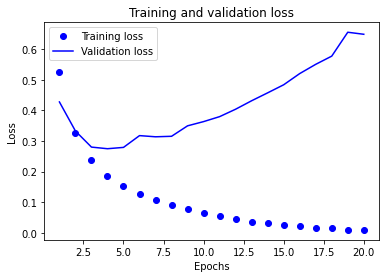

In [25]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

훈련 세트와 검증 세트에 대한 에포크별 정확도의 변화는 다음과 같다.

- 훈련 세트: 정확도 계속 증가
- 검증 세트: 다섯째 에포크 전후 정체 및 감소. 과대적합(overfitting) 발생.

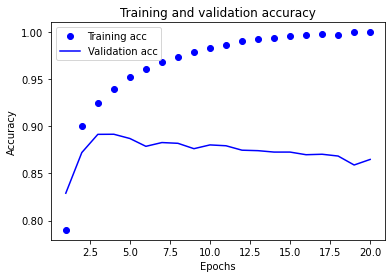

In [26]:
plt.clf()    # 이전 이미지 삭제

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### 과대적합

과대적합은 모델이 훈련 세트에 익숙해진다는 의미이다.
시험에 비유하면 연습문제 유형을 모두 외워서 최종적으로 연습문제를 100점 맞는 것을 나타낸다.

과대적합을 방지하기 위한 다양한 기법은 다음 장(chapter)에서 다룬다.
위 문제의 경우 넷째 또는 다섯째 에포크 정도만 훈련 반복을 진행하면 된다.
아래 코드는 다시 처음부터 네 번의 에포크만을 사용하여 훈련한 결과를 보여준다.

In [27]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)

Epoch 1/4
49/49 [==============================] - 1s 9ms/step - loss: 0.4522 - accuracy: 0.8242
Epoch 2/4
49/49 [==============================] - 0s 9ms/step - loss: 0.2647 - accuracy: 0.9091
Epoch 3/4
49/49 [==============================] - 0s 9ms/step - loss: 0.2028 - accuracy: 0.9283
Epoch 4/4
49/49 [==============================] - 0s 9ms/step - loss: 0.1711 - accuracy: 0.9396


테스트 세트에 대한 성능은 아래와 같이 88% 정도의 정확도를 보인다.
앞으로 보다 좋은 성능의 모델을 살펴볼 것이며, 현존하는 가장 좋은 모델의 정확도는 95% 정도이다.

In [28]:
results = model.evaluate(x_test, y_test)
results

782/782 [==============================] - 2s 2ms/step - loss: 0.2918 - accuracy: 0.8839


[0.291790246963501, 0.8839200139045715]

### 모델 활용

훈련된 모델을 활용하려면 `predict()` 메서드를 이용한다.

- 0,99 이상 또는 0.01 이하의 경우: 매우 확실한 예측
- 0.4 ~ 0.6: 불확실한 예측

In [29]:
model.predict(x_test)

array([[0.18953939],
       [0.9982426 ],
       [0.8552132 ],
       ...,
       [0.15310504],
       [0.07927683],
       [0.60871553]], dtype=float32)

### 연습문제

1. 두 개의 은닉층 대신 1 개 또는 3 개의 은닉층을 사용할 때 
    검증 세트와 테스트 세트에 대한 평가지표의 변화를 확인하라.
1. 각 은닉층에 사용된 유닛(unit)의 수를 8, 32, 64 등으로 변화시킨 후 
    검증 세트와 테스트 세트에 대한 평가지표의 변화를 확인하라.
1. `binary_crossentropy` 대신 `mse`를 손실함수로 지정한 후 
    검증 세트와 테스트 세트에 대한 평가지표의 변화를 확인하라.
1. `relu` 함수 대신 이전에 많이 사용됐었던 `tanh` 함수를 손실함수로 지정한 후 
    검증 세트와 테스트 세트에 대한 평가지표의 변화를 확인하라.

### Wrapping up

## Classifying newswires: a multiclass classification example

### The Reuters dataset

**Loading the Reuters dataset**

In [30]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2121728/2110848 [==============================] - 0s 0us/step


In [31]:
len(train_data)

8982

In [32]:
len(test_data)

2246

In [33]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

**Decoding newswires back to text**

In [34]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])

565248/550378 [==============================] - 0s 0us/step


In [35]:
train_labels[10]

3

### Preparing the data

**Encoding the input data**

In [36]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

**Encoding the labels**

In [37]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [38]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### Building your model

**Model definition**

In [39]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

**Compiling the model**

In [40]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

In [41]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

**Training the model**

In [42]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 29ms/step - loss: 2.5616 - accuracy: 0.5329 - val_loss: 1.6609 - val_accuracy: 0.6550
Epoch 2/20
16/16 [==============================] - 0s 11ms/step - loss: 1.3641 - accuracy: 0.7177 - val_loss: 1.2768 - val_accuracy: 0.7120
Epoch 3/20
16/16 [==============================] - 0s 12ms/step - loss: 1.0164 - accuracy: 0.7801 - val_loss: 1.1266 - val_accuracy: 0.7700
Epoch 4/20
16/16 [==============================] - 0s 11ms/step - loss: 0.7960 - accuracy: 0.8312 - val_loss: 1.0328 - val_accuracy: 0.7790
Epoch 5/20
16/16 [==============================] - 0s 12ms/step - loss: 0.6308 - accuracy: 0.8686 - val_loss: 0.9581 - val_accuracy: 0.7970
Epoch 6/20
16/16 [==============================] - 0s 11ms/step - loss: 0.5038 - accuracy: 0.8969 - val_loss: 0.9091 - val_accuracy: 0.8180
Epoch 7/20
16/16 [==============================] - 0s 11ms/step - loss: 0.4060 - accuracy: 0.9161 - val_loss: 0.9119 - val_accuracy: 0.8130
Epoch 8/20
16

**Plotting the training and validation loss**

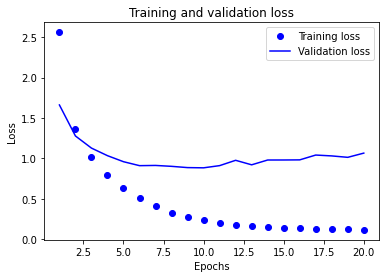

In [43]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

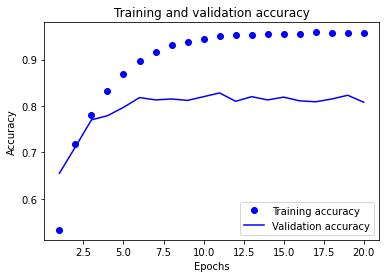

In [44]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

In [45]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 0s 9ms/step - loss: 2.5178 - accuracy: 0.5353
Epoch 2/9
18/18 [==============================] - 0s 9ms/step - loss: 1.3634 - accuracy: 0.7077
Epoch 3/9
18/18 [==============================] - 0s 9ms/step - loss: 1.0046 - accuracy: 0.7825
Epoch 4/9
18/18 [==============================] - 0s 9ms/step - loss: 0.7858 - accuracy: 0.8357
Epoch 5/9
18/18 [==============================] - 0s 10ms/step - loss: 0.6274 - accuracy: 0.8709
Epoch 6/9
18/18 [==============================] - 0s 10ms/step - loss: 0.5004 - accuracy: 0.8949
Epoch 7/9
18/18 [==============================] - 0s 9ms/step - loss: 0.4041 - accuracy: 0.9154
Epoch 8/9
18/18 [==============================] - 0s 8ms/step - loss: 0.3319 - accuracy: 0.9286
Epoch 9/9
71/71 [==============================] - 0s 2ms/step - loss: 0.9463 - accuracy: 0.7921


In [46]:
results

[0.946312427520752, 0.7920747995376587]

In [47]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.1745325022261799

### Generating predictions on new data

In [48]:
predictions = model.predict(x_test)

In [49]:
predictions[0].shape

(46,)

In [50]:
np.sum(predictions[0])

0.99999994

In [51]:
np.argmax(predictions[0])

3

### A different way to handle the labels and the loss

In [52]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [53]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### The importance of having sufficiently large intermediate layers

**A model with an information bottleneck**

In [54]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 8ms/step - loss: 2.8483 - accuracy: 0.3464 - val_loss: 2.2643 - val_accuracy: 0.3700
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 1.9592 - accuracy: 0.4002 - val_loss: 1.8113 - val_accuracy: 0.4250
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.5125 - accuracy: 0.5670 - val_loss: 1.5151 - val_accuracy: 0.6590
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1.2648 - accuracy: 0.6835 - val_loss: 1.4311 - val_accuracy: 0.6590
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.1382 - accuracy: 0.6951 - val_loss: 1.4075 - val_accuracy: 0.6580
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 1.0495 - accuracy: 0.7157 - val_loss: 1.4057 - val_accuracy: 0.6620
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.9826 - accuracy: 0.7344 - val_loss: 1.4051 - val_accuracy: 0.6730
Epoch 8/20
63/63 [==

### Further experiments

### Wrapping up

## Predicting house prices: a regression example

### The Boston Housing Price dataset

**Loading the Boston housing dataset**

In [55]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [56]:
train_data.shape

(404, 13)

In [57]:
test_data.shape

(102, 13)

In [58]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### Preparing the data

**Normalizing the data**

In [59]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Building your model

**Model definition**

In [60]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating your approach using K-fold validation

**K-fold validation**

In [61]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [62]:
all_scores

[2.024545907974243, 2.467670440673828, 2.3559298515319824, 2.5102298259735107]

In [63]:
np.mean(all_scores)

2.339594006538391

**Saving the validation logs at each fold**

In [64]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


**Building the history of successive mean K-fold validation scores**

In [65]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores**

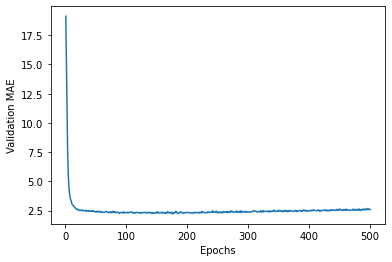

In [66]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Plotting validation scores, excluding the first 10 data points**

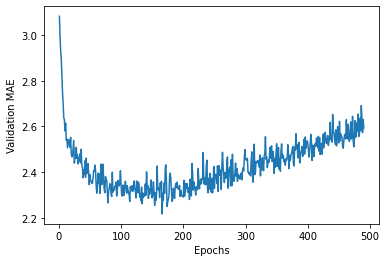

In [67]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Training the final model**

In [68]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 14.3330 - mae: 2.4183


In [69]:
test_mae_score

2.4182708263397217

### Generating predictions on new data

In [70]:
predictions = model.predict(test_data)
predictions[0]

array([6.809031], dtype=float32)

### Wrapping up

## Chapter summary